## *Seminar 7: Heston Model (Part I)*

## 1. Heston model

#### 1.1 SDE

In Heston model the spot dynamics is given by the following SDE:

$$dS_t = (r - q)S_t dt + \sqrt{V_t} S_t  dW^{1}_t, \qquad S_0 = s > 0,$$

$$dV_t = \kappa (\theta - V_t) dt + \sigma \sqrt{V_t} dW^{2}_t, \qquad V_0 = v > 0,$$

$$dW_t^1 dW_t^2 = \rho dt.$$

The variables $\kappa > 0$, $\theta > 0$, $\sigma > 0$, $\rho \in (−1, 1)$ are the model parameters. The process $V_t$ is the stochastic variance, and $\sigma_t = \sqrt{V_t}$ is the stochastic volatility. The equation has a unique strong solutioin $(S_t, V_t)$.  If $2 \kappa \theta \geq \sigma^2$, then the process $V_t$ is strictly positive. Otherwise, $V_t$ is non-negative. The process $S_t$ is always strictly positive as it is a stochastic exponent. 



#### 1.2 Moments characteristics of $V_t$

To analyze the basic properties of $V_t$, lets find its first two moments. First of all, rewrite the SDE as an integral equation 

$$V_t = v + \int_{0}^{t} \kappa (\theta - V_s) ds + \int_{0}^{t} \sigma \sqrt{V_s} dW_s.$$

Then, taking the expectation of both sides, we get 

$$\mathbb{E} V_t = v + \int_{0}^{t} \kappa (\theta - \mathbb{E} V_s) ds.$$

Thus, denoting by $f(t) := \mathbb{E} V_t$ and differentiating both sides wrt $t$, we get 

$$\begin{cases} \dot f(t) = \kappa (\theta - f(t)) \\ f(0) = v \end{cases} $$

The solution of such non-homogeneous differential equation is 

$$\mathbb{E} V_t \equiv f(t) = \theta + (v - \theta)e^{-\kappa t},$$

so $\mathbb{E} V_t$ tends to $\theta$ as $t \to \infty$ with the speed $\kappa$. That is the parameters can be intepreted as 

1. $\kappa$ is the speed of mean-reversion.

2. $\theta$ is the long-term mean.


The same way, we can find $\mathbb{E} V_t^2$ and $\mathbb{D} V_t^2$. That is, 

$$\mathbb{D} V_t^2 = v \frac{\sigma^2}{\kappa} \left( e^{-\kappa t} - e^{-2 \kappa t} \right) + \frac{\theta \sigma^2}{2 \kappa} (1 - e^{-\kappa t})^2.$$

So $\mathbb{D} V_t^2$ tends to $\dfrac{\theta \sigma^2}{2 \kappa}$ as $t \to \infty.$ 

#### 1.3 Heston Options Pricing

The semi-closed-form Heston call option price at time $t$ with strike $K$, time to expiration $T$, and the initial forward price $F_t$ can be obtained from the representation through the exercise probabilities and the characteristic functions. That is, under the forward measure $P$

$$C(T, K; F)= e^{-r(T-t)} \mathbb{E}^{\mathbb{P}} [ (F_T - K)_+ | F_t = F] = e^{-rT} \left( F_t \cdot \tilde \Pi(t, \ln F_t, V_t)  - K \cdot \Pi(t, \ln F_t, V_t) \right),$$

where 

$$\tilde \Pi(t, x, v) = \frac{1}{2} + \frac{1}{\pi} \int_{0}^{\infty} Re\left( \frac{e^{-iu \ln K \tilde \phi(t, x, v; u)}}{iu}\right)  du,$$
$$\Pi(t, x, v) = \frac{1}{2} + \frac{1}{\pi} \int_{0}^{\infty} Re\left( \frac{e^{-iu \ln K \phi(t, x, v; u)}}{iu}\right)du,$$

are conditonal exercies probabilities, i.e. 

$$\tilde \Pi(t, x, v) = \tilde P(\ln F_T \geq \ln K | \ln F_t = x, V_t = v),$$
$$\Pi(t, x, v) = P(\ln F_T \geq \ln K | \ln F_t = x, V_t = v),$$
$$d \tilde P = F_T / F_0 \cdot dP.$$

and $\phi(t, x, v; u)$ is a conditional log-forward characteristic function, given by 

$$\phi(t, x, v; u) = e^{C(T - t, u) + D(T - t, u) v + iux},$$
$$\tilde \phi(t, x, v; u) = \frac{\phi(t, x, v; u - i)}{\phi(t, x, v; -i)},$$
$$C(\tau, u) = \frac{\kappa \theta}{\sigma^2} \left( (\kappa - \rho \sigma iu - d(u))\tau - 2 \ln \left(  \frac{1 - g(u) e^{-d(u) \tau}}{1 - g(u)}\right) \right),$$
$$D(\tau, u) = \frac{\kappa - \rho \sigma iu - d(u)}{\sigma^2} \left( \frac{1 - e^{-d(u) \tau}}{1 - g(u)e^{-d(u)\tau}}\right),$$
$$d(u) = \sqrt{(\rho \sigma iu - \kappa)^2 + \sigma^2 (iu + u^2)}, \quad g(u) = \frac{\rho \sigma iu - \kappa + d(u)}{\rho \sigma iu - \kappa - d(u)}.$$


In [22]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from py_vollib.black_scholes.implied_volatility import implied_volatility
from typing import Union
from scipy import optimize
import cmath
import math
import scipy.integrate as intg
from dataclasses import dataclass
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
implied_volatility_vec = np.vectorize(implied_volatility)


In [23]:
def iv_black_scholes(price: Union[float, np.ndarray], S: float, 
                     K: Union[float, np.ndarray], t: Union[float, np.ndarray], 
                     r: float, is_call: bool):
    """
    Returns implied volatility from given options' prices. 
    """
    return implied_volatility_vec(price=price, S=S, K=K, t=t, r=r, flag='c' if is_call else 'p') 

In [24]:
def heston_cf(s, v, kappa, theta, sigma, rho, u, t):
    """Characteristic function of the log-price in the Heston model."""
    d = cmath.sqrt((rho * sigma * u * 1j - kappa) ** 2 + sigma ** 2 * (u * 1j + u ** 2))
    g = ((rho * sigma * u * 1j - kappa + d) / (rho * sigma * u * 1j - kappa - d))
    C = (kappa * theta / sigma ** 2 * (
        t * (kappa - rho * sigma * u * 1j - d) -
        2 * cmath.log((1 - g * cmath.exp(-d * t)) / (1 - g))))
    D = ((kappa - rho * sigma * u * 1j - d) / sigma ** 2 *
         ((1 - cmath.exp(-d * t)) / (1 - g * cmath.exp(-d * t))))
    return cmath.exp(C + D * v + u * math.log(s) * 1j)

In [25]:
def heston_integrand(u, t, k,  s, r, v, kappa, theta, sigma, rho):
    """Integrand in Heston's formula."""
    return (cmath.exp(-1j * u * math.log(k)) / (1j * u) *
            (cmath.exp(r * t) * heston_cf(s, v, kappa, theta, sigma, rho, u - 1j, t) -
             k * heston_cf(s, v, kappa, theta, sigma, rho, u, t))).real


In [26]:
@dataclass
class HestonParams:
    v: float # initial variance V_0
    kappa: float # speed of mean-reversion 
    theta: float # long-term mean
    sigma: float # vol of vol
    rho: float # correlation between brownian motions

In [27]:
def heston_scalar(t: float, k: float, s: float, r: float, is_call: bool, heston_params: HestonParams) -> float:
    """Computes the price of a call option by Heston's semi-closed formula.

    This is an auxiliary function which works with scalar expiration time
    and strike. It is called by `call_price`, which allows vectorization.
    """
    call_price = (0.5 * (s - math.exp(- r * t) * k) +
                  1 / math.pi * math.exp(- r * t) * 
                  intg.quad(
                    heston_integrand,
                    0, math.inf,
                    args=(t, k, s, r, heston_params.v, heston_params.kappa, heston_params.theta,
                    heston_params.sigma, heston_params.rho))[0])
    if is_call:
        return call_price
    
    return call_price + k * np.exp(- r * t) - s

In [28]:
def heston(t: Union[float, np.ndarray], 
           k: Union[float, np.ndarray], 
           s: float, r: float, 
           is_call: Union[bool, np.ndarray], 
           heston_params: HestonParams) -> Union[float, np.ndarray]:
    """Computes the price of a call option by Heston's semi-closed formula.

        Args:
            t: Expiration time (float or ndarray).
            k: Strike (float or ndarray).
            s: Asset price S_0.
            r: Interest rate r. 

        Returns:
            If `t` and `k` are scalars, returns the price of a call option as a
            scalar value. If `t` and/or `k` are arrays, applies NumPy
            broadcasting rules and returns an array of prices.
    """
    b = np.broadcast(t, k)
    if b.nd:  # Vector arguments were supplied
        return np.fromiter(
            (heston_scalar(t_, k_, s, r, is_call, heston_params) for (t_, k_) in b),
            count=b.size, dtype=float).reshape(b.shape)
    else:
        return heston(t, k, s, r, is_call, heston_params)

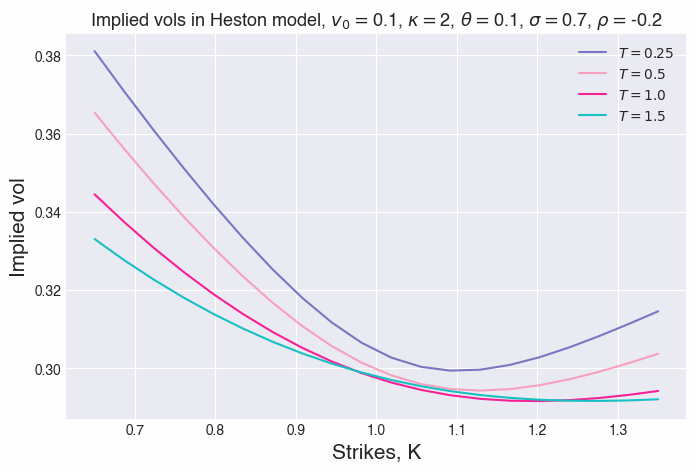

In [29]:
s = 1; r = 0.02; is_call=True
heston_params = HestonParams(v=0.1, kappa=2, theta=0.1, sigma=0.7, rho=-0.2)
strikes = np.linspace(s * 0.65, s * 1.35, 20)
times = np.array([0.25, 0.5, 1, 1.5])

prices_heston = np.zeros((times.size, strikes.size))
ivs_bs = np.zeros((times.size, strikes.size))
for i, strike in enumerate(strikes):
    is_call = True if strike > s else False
    prices_heston[:, i] = heston(t=times, k=strike, s=s, r=r, is_call=is_call, heston_params=heston_params)
    ivs_bs[:, i] = iv_black_scholes(price=prices_heston[:, i], S=s, K=strike, t=times, r=r, is_call=is_call)

plt.figure(figsize=(8, 5))
for i, time in enumerate(times):
    plt.plot(strikes, ivs_bs[i, :], label="$T={}$".format(times[i]))

plt.title("Implied vols in Heston model, $v_0=${}, $\kappa=${}, $\\theta=${}, $\sigma=${}, $\\rho=${}".format(heston_params.v, heston_params.kappa, 
                                                                                                            heston_params.theta, heston_params.sigma, heston_params.rho), fontsize=13)
plt.ylabel("Implied vol", fontsize=15)
plt.xlabel("Strikes, K", fontsize=15)
plt.legend()
plt.show(True)

#### 1.4 Effects of $\kappa, \theta, v_0, \sigma, \rho$ on implied vol curve

##### 1.4.1 Initial variance $v_0$

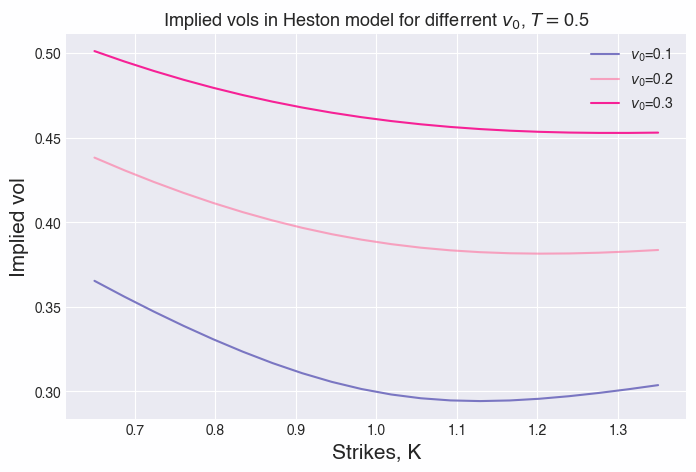

In [30]:
s = 1; r = 0.02; is_call=True
heston_params = [HestonParams(v=0.1, kappa=2, theta=0.1, sigma=0.7, rho=-0.2),
                 HestonParams(v=0.2, kappa=2, theta=0.1, sigma=0.7, rho=-0.2),
                 HestonParams(v=0.3, kappa=2, theta=0.1, sigma=0.7, rho=-0.2)]

strikes = np.linspace(s * 0.65, s * 1.35, 20)
times = np.array([0.5])
prices_heston = np.zeros((len(heston_params), times.size, strikes.size))
ivs_bs = np.zeros((len(heston_params), times.size, strikes.size))

for j, heston_param in enumerate(heston_params):
    for i, strike in enumerate(strikes):
        is_call = True if strike > s else False
        prices_heston[j, :, i] = heston(t=times, k=strike, s=s, r=r, is_call=is_call, heston_params=heston_param)
        ivs_bs[j, :, i] = iv_black_scholes(price=prices_heston[j, :, i], S=s, K=strike, t=times, r=r, is_call=is_call)

plt.figure(figsize=(8, 5))
for i, param in enumerate(heston_params):
    plt.plot(strikes, ivs_bs[i, :, :].flatten(), label="$v_0$={}".format(param.v))

plt.title("Implied vols in Heston model for differrent $v_0$, $T=${}".format(times[0]), fontsize=13)
plt.ylabel("Implied vol", fontsize=15)
plt.xlabel("Strikes, K", fontsize=15)
plt.legend()
plt.show(True)

**Effect:** higher initial vol leads to the shift of implied volatility curve. This effect appears especially for short-term options. 

##### 1.4.2 Vol of vol $\sigma$

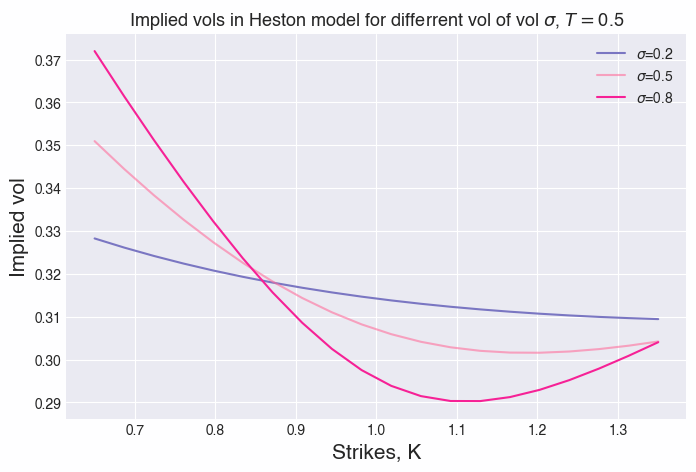

In [31]:
s = 1; r = 0.02; is_call=True
heston_params = [HestonParams(v=0.1, kappa=2, theta=0.1, sigma=0.2, rho=-0.2),
                 HestonParams(v=0.1, kappa=2, theta=0.1, sigma=0.5, rho=-0.2),
                 HestonParams(v=0.1, kappa=2, theta=0.1, sigma=0.8, rho=-0.2)]

strikes = np.linspace(s * 0.65, s * 1.35, 20)
times = np.array([0.5])
prices_heston = np.zeros((len(heston_params), times.size, strikes.size))
ivs_bs = np.zeros((len(heston_params), times.size, strikes.size))

for j, heston_param in enumerate(heston_params):
    for i, strike in enumerate(strikes):
        is_call = True if strike > s else False
        prices_heston[j, :, i] = heston(t=times, k=strike, s=s, r=r, is_call=is_call, heston_params=heston_param)
        ivs_bs[j, :, i] = iv_black_scholes(price=prices_heston[j, :, i], S=s, K=strike, t=times, r=r, is_call=is_call)

plt.figure(figsize=(8, 5))
for i, param in enumerate(heston_params):
    plt.plot(strikes, ivs_bs[i, :, :].flatten(), label="$\sigma$={}".format(param.sigma))

plt.title("Implied vols in Heston model for differrent vol of vol $\sigma$, $T=${}".format(times[0]), fontsize=13)
plt.ylabel("Implied vol", fontsize=15)
plt.xlabel("Strikes, K", fontsize=15)
plt.legend()
plt.show(True)

**Effect:** higher vol of vol $\sigma$ leads to the wide spread of volatilites which is reflected in the increase of the curvature of implied vol. 

##### 1.4.3 Correlation $\rho$

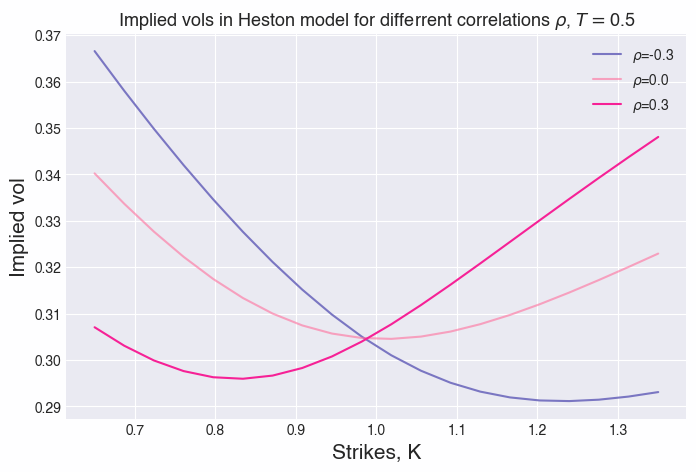

In [32]:
s = 1; r = 0.02; is_call=True
heston_params = [HestonParams(v=0.1, kappa=2, theta=0.1, sigma=0.6, rho=-0.3),
                 HestonParams(v=0.1, kappa=2, theta=0.1, sigma=0.6, rho=0.0),
                 HestonParams(v=0.1, kappa=2, theta=0.1, sigma=0.6, rho=0.3)]

strikes = np.linspace(s * 0.65, s * 1.35, 20)
times = np.array([0.5])
prices_heston = np.zeros((len(heston_params), times.size, strikes.size))
ivs_bs = np.zeros((len(heston_params), times.size, strikes.size))

for j, heston_param in enumerate(heston_params):
    for i, strike in enumerate(strikes):
        is_call = True if strike > s else False
        prices_heston[j, :, i] = heston(t=times, k=strike, s=s, r=r, is_call=is_call, heston_params=heston_param)
        ivs_bs[j, :, i] = iv_black_scholes(price=prices_heston[j, :, i], S=s, K=strike, t=times, r=r, is_call=is_call)

plt.figure(figsize=(8, 5))
for i, param in enumerate(heston_params):
    plt.plot(strikes, ivs_bs[i, :, :].flatten(), label="$\\rho$={}".format(param.rho))

plt.title("Implied vols in Heston model for differrent correlations $\\rho$, $T=${}".format(times[0]), fontsize=13)
plt.ylabel("Implied vol", fontsize=15)
plt.xlabel("Strikes, K", fontsize=15)
plt.legend()
plt.show(True)

**Effect:** correlation corresponds to the slope of the implied vol. 

##### 1.4.4 Mean reversion $\kappa$

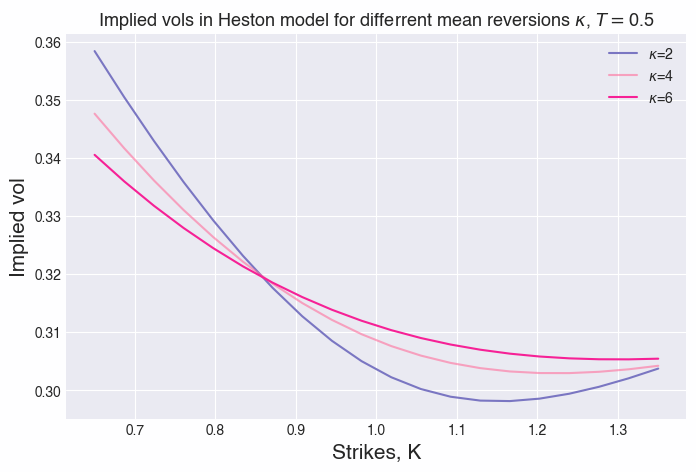

In [12]:
s = 1; r = 0.02; is_call=True
heston_params = [HestonParams(v=0.1, kappa=2, theta=0.1, sigma=0.6, rho=-0.2),
                 HestonParams(v=0.1, kappa=4, theta=0.1, sigma=0.6, rho=-0.2),
                 HestonParams(v=0.1, kappa=6, theta=0.1, sigma=0.6, rho=-0.2)]

strikes = np.linspace(s * 0.65, s * 1.35, 20)
times = np.array([0.5])
prices_heston = np.zeros((len(heston_params), times.size, strikes.size))
ivs_bs = np.zeros((len(heston_params), times.size, strikes.size))

for j, heston_param in enumerate(heston_params):
    for i, strike in enumerate(strikes):
        is_call = True if strike > s else False
        prices_heston[j, :, i] = heston(t=times, k=strike, s=s, r=r, is_call=is_call, heston_params=heston_param)
        ivs_bs[j, :, i] = iv_black_scholes(price=prices_heston[j, :, i], S=s, K=strike, t=times, r=r, is_call=is_call)

plt.figure(figsize=(8, 5))
for i, param in enumerate(heston_params):
    plt.plot(strikes, ivs_bs[i, :, :].flatten(), label="$\kappa$={}".format(param.kappa))

plt.title("Implied vols in Heston model for differrent mean reversions $\kappa$, $T=${}".format(times[0]), fontsize=13)
plt.ylabel("Implied vol", fontsize=15)
plt.xlabel("Strikes, K", fontsize=15)
plt.legend()
plt.show(True)

**Effect:** higher mean reversion $\kappa$ leads to faster reversion to the long-term mean $\theta$, hence to the "constant" volatility, which is the Black-Scholes case. This parameter is also a proxy for the curvature of implied vol. 

##### 1.4.5 Long-term mean $\theta$

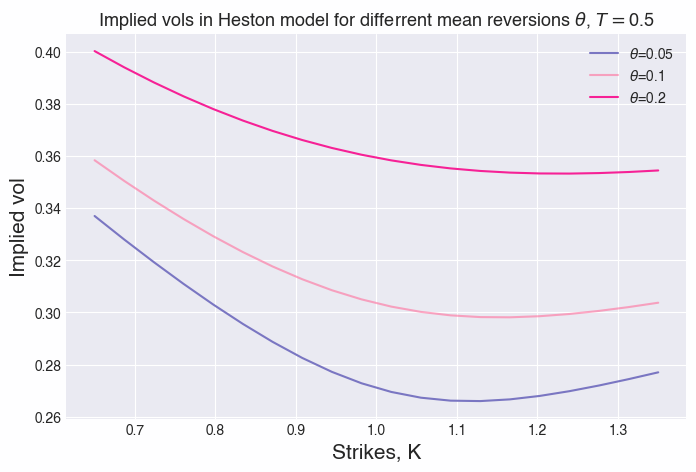

In [13]:
s = 1; r = 0.02; is_call=True
heston_params = [HestonParams(v=0.1, kappa=2, theta=0.05, sigma=0.6, rho=-0.2),
                 HestonParams(v=0.1, kappa=2, theta=0.1, sigma=0.6, rho=-0.2),
                 HestonParams(v=0.1, kappa=2, theta=0.2, sigma=0.6, rho=-0.2)]

strikes = np.linspace(s * 0.65, s * 1.35, 20)
times = np.array([0.5])
prices_heston = np.zeros((len(heston_params), times.size, strikes.size))
ivs_bs = np.zeros((len(heston_params), times.size, strikes.size))

for j, heston_param in enumerate(heston_params):
    for i, strike in enumerate(strikes):
        is_call = True if strike > s else False
        prices_heston[j, :, i] = heston(t=times, k=strike, s=s, r=r, is_call=is_call, heston_params=heston_param)
        ivs_bs[j, :, i] = iv_black_scholes(price=prices_heston[j, :, i], S=s, K=strike, t=times, r=r, is_call=is_call)

plt.figure(figsize=(8, 5))
for i, param in enumerate(heston_params):
    plt.plot(strikes, ivs_bs[i, :, :].flatten(), label="$\\theta$={}".format(param.theta))

plt.title("Implied vols in Heston model for differrent mean reversions $\\theta$, $T=${}".format(times[0]), fontsize=13)
plt.ylabel("Implied vol", fontsize=15)
plt.xlabel("Strikes, K", fontsize=15)
plt.legend()
plt.show(True)

**Effect:** higher terminal vol (long-term mean) leads to the shift of implied volatility curve. This effect appears especially for long-term options. 

#### 1.5 Calibration

In [14]:
def objective(p, t, k, s, r, iv):
    prices_heston = np.zeros((t.size, k.size))
    ivs_bs = np.zeros((t.size, k.size))
    for i, strike in enumerate(k):
        is_call = True if strike > s else False
        prices_heston[:, i] = heston(t=times, k=strike, s=s, r=r, is_call=is_call, heston_params=HestonParams(*p))
        ivs_bs[:, i] = iv_black_scholes(price=prices_heston[:, i], S=s, K=strike, t=t, r=r, is_call=is_call)
    
    return np.linalg.norm(ivs_bs - iv)

In [15]:
def calibrate(t: Union[float, np.ndarray], k: np.ndarray, 
              iv: np.ndarray, s: float, r: float = 0, min_method: str = "L-BFGS-B"):
        """Calibrates the parameters of the Heston model.

        This function finds the parameters `v`, `kappa`, `sigma`, `theta`,
        `rho` of the model which minimize the sum of squares of the differences
        between market and model implied volatilities. Returns an instance of
        the class with the calibrated parameters.

        Args:
            t : Expiration time (scalar or array).
            k: Array of strikes.
            iv: Array of market implied volatilities.
            s: Initial price.
            r: Interest rate.
            min_method: Minimization method to be used, as accepted by
                `scipy.optimize.minimize`. The method must be able to handle
                bounds.
        """
        v0 = iv[np.abs(k-s).argmin()]**2  # ATM variance
        res = optimize.minimize(
            fun=objective,
            x0=(v0, 1.0, v0, 1.0, -0.5),  # (v, kappa, theta, sigma, rho)
            method=min_method,
            args=(t, k, s, r, iv),
            bounds=[(0, math.inf), (0, math.inf), (0, math.inf), (0, math.inf),
                    (-1, 1)])
        return res

In [16]:
s = 1; r = 0.02; is_call=True
heston_params = HestonParams(v=0.1, kappa=2, theta=0.1, sigma=0.7, rho=-0.2)
strikes = np.linspace(s * 0.65, s * 1.35, 20)
times = np.array([0.5])

prices_heston = np.zeros((times.size, strikes.size))
ivs_bs = np.zeros((times.size, strikes.size))
for i, strike in enumerate(strikes):
    is_call = True if strike > s else False
    prices_heston[:, i] = heston(t=times, k=strike, s=s, r=r, is_call=is_call, heston_params=heston_params)
    ivs_bs[:, i] = iv_black_scholes(price=prices_heston[:, i], S=s, K=strike, t=times, r=r, is_call=is_call)

In [17]:
res = calibrate(t=times, k=strikes, iv=ivs_bs.flatten(), s=s, r=r)

In [19]:
res.x

array([ 0.03500459,  1.06646039,  0.32427515,  0.71704755, -0.20896564])

In [20]:
heston_params_calibrated = HestonParams(*res.x)

prices_heston_calibrated = np.zeros((times.size, strikes.size))
ivs_bs_calibrated = np.zeros((times.size, strikes.size))
for i, strike in enumerate(strikes):
    is_call = True if strike > s else False
    prices_heston_calibrated[:, i] = heston(t=times, k=strike, s=s, r=r, is_call=is_call, heston_params=heston_params_calibrated)
    ivs_bs_calibrated[:, i] = iv_black_scholes(price=prices_heston_calibrated[:, i], S=s, K=strike, t=times, r=r, is_call=is_call)

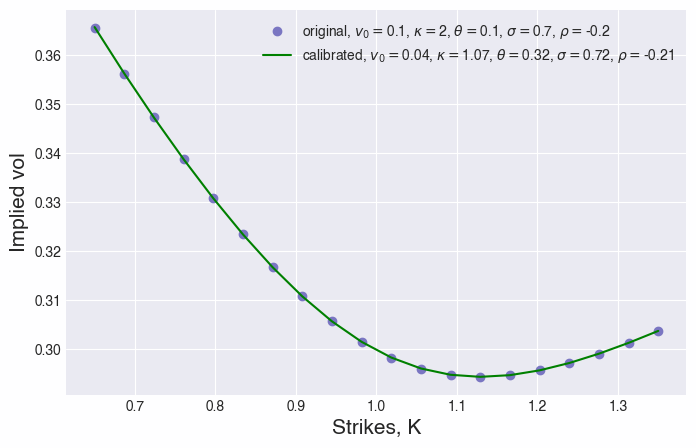

In [21]:
plt.figure(figsize=(8, 5))
plt.scatter(strikes, ivs_bs[0], label="original, $v_0=${}, $\kappa=${}, $\\theta=${}, $\sigma=${}, $\\rho=${}".format(heston_params.v, heston_params.kappa, 
                                                                                                                      heston_params.theta, heston_params.sigma, heston_params.rho))
plt.plot(strikes, ivs_bs_calibrated[0], color="green", label="calibrated, $v_0=${}, $\kappa=${}, $\\theta=${}, $\sigma=${}, $\\rho=${}".format(round(heston_params_calibrated.v, 2), round(heston_params_calibrated.kappa, 2), 
                                                                                                                      round(heston_params_calibrated.theta, 2), round(heston_params_calibrated.sigma, 2), round(heston_params_calibrated.rho, 2)))


plt.ylabel("Implied vol", fontsize=15)
plt.xlabel("Strikes, K", fontsize=15)
plt.legend()
plt.show(True)